In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import permutations
from sklearn.manifold import MDS
import matplotlib.animation as animation

## Test problem

In [2]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

In [3]:
def isMatrixSymmetric(matrix):
    return np.allclose(matrix, matrix.T)

def doesMatrixHaveZeroDiagonal(matrix):
    return np.allclose(matrix.diagonal(), 0.0)

def doesMatrixHaveNegativeValues(matrix):
    return np.any(matrix < 0)

def isTriangleInequalitySatisfied(matrix):
    return all(
        matrix[i, k] <= matrix[i, j] + matrix[j, k]
        for i, j, k in permutations(range(matrix.shape[0]), 3)
    )

Solution can be represented in 2 ways. As a matrix with 0 and 1.
Solution represented as a matrix with Aij = 1 if the path goes from city i to city j.

Or as an array of integers when each one points to the next.

It's easier to verify some proprieties on the matrix and the list is easier to manipulate for the algorithm

In [4]:
# Both functions do not check if negative values,
# zero diagonal and symmetry are satisfied and triangle inequality

def generateRandomSolutionMatrix(num_cities):
    solution = list(range(num_cities))
    np.random.shuffle(solution)
    random_solution = np.zeros((num_cities, num_cities), dtype=int)
    for i in range(num_cities):
        j = (i + 1) % num_cities
        random_solution[solution[i], solution[j]] = 1
    return random_solution

def generateRandomSolutionArray(num_cities):
    solution = list(range(num_cities))
    np.random.shuffle(solution)
    return solution

test_solution_array = generateRandomSolutionArray(len(CITIES))
print(test_solution_array)
test_solution_matrix = generateRandomSolutionMatrix(len(CITIES))
print(test_solution_matrix)

[15, 11, 10, 3, 18, 4, 0, 6, 14, 16, 7, 8, 1, 5, 12, 19, 9, 13, 2, 17]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


In [5]:
def isValidSolution(solution_matrix):
    n = solution_matrix.shape[0]
    for i in range(n):
        if np.sum(solution_matrix[i, :]) != 1:
            return False
        if np.sum(solution_matrix[:, i]) != 1:
            return False
    if solution_matrix.trace() != 0:
        return False
    graph = nx.DiGraph(solution_matrix)
    cycles = list(nx.simple_cycles(graph))
    if len(cycles) != 1 and len(cycles[0]) != n:
        return False
    return True

assert isValidSolution(test_solution_matrix)

In [6]:
def matrix2array(solution_matrix):
    path = []
    current_city = 0
    visited = set()
    while len(visited) < len(solution_matrix):
        path.append(current_city)
        visited.add(current_city)
        next_city = np.argmax(solution_matrix[current_city])
        current_city = next_city
    return path

def array2matrix(path):
    size = len(path)
    solution_matrix = np.zeros((size, size), dtype=int)
    for i in range(size):
        j = (i + 1) % size
        solution_matrix[path[i], path[j]] = 1
    return solution_matrix

assert np.array_equal(test_solution_matrix, array2matrix(matrix2array(test_solution_matrix)))

In [7]:
# Greedy initial solution
def greedyInitialSolution(distance_matrix):
    n = distance_matrix.shape[0]
    unvisited = set(range(n))
    current_city = 0
    path = [current_city]
    unvisited.remove(current_city)
    while unvisited:
        list_available_cities_distances = [(distance_matrix[current_city][city], city) for city in unvisited]
        next_city = min(list_available_cities_distances, key=lambda x: x[0])[1]
        path.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city
    return path

In [8]:
# Test greedy initial solution
greedy_solution = greedyInitialSolution(test_problem)
print("Greedy solution as array:", greedy_solution)
greedy_solution_matrix = array2matrix(greedy_solution)
print("Greedy solution as matrix:\n", greedy_solution_matrix)

assert isValidSolution(greedy_solution_matrix)

Greedy solution as array: [0, 2, 8, 15, 12, 9, 4, 7, 17, 6, 19, 18, 16, 11, 13, 10, 14, 1, 5, 3]
Greedy solution as matrix:
 [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


## Some plots

In [9]:
# Takes the list of total distances over iterations and plots it
def plotEvolution(evolution_distance, title = ""):
    plt.plot(evolution_distance)
    plt.xlabel('Iteration')
    plt.ylabel('Total Distance')
    plt.title(title)
    plt.grid()
    plt.show()

To plot the path in a meaningful way, we need to calculate the coordinates of the city on a map (with only the distance matrix)

It's done with the algorithm taken from: https://math.stackexchange.com/questions/156161/finding-the-coordinates-of-points-from-distance-matrix

Coordinates are translated/rotated, they are not fixed since we have only the distance, so the actual values don't matter.

Do not always returns 2D coordinates.

"Note that, if the data points can be embedded in k-dimensional space, only k columns of X will be non-zero (corresponding to k non-zero eigenvalues of M)."

That means cities can be multidimensional and live on an hypermap.

In [10]:
def distanceMatrixToCoordinates(D):
    n = D.shape[0]    # distance_matrix is n x n

    M = np.zeros_like(D)
    for i in range(n):
        for j in range(n):
            M[i, j] = 0.5 * (D[0, j]**2 + D[i, 0]**2 - D[i, j]**2)
    # Matrix decomposition
    eigenvalues, eigenvectors = np.linalg.eig(M)
    assert np.allclose(eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T, M)

    X = eigenvectors @ np.diag(np.sqrt(np.abs(eigenvalues)))
    
    # Indices where eigenvalues are too small (considered as zero or negative)
    small_eigenvalue_indices = np.where(np.abs(eigenvalues) < 1e-10)[0]
    X = np.delete(X, small_eigenvalue_indices, axis=1)
    
    return X

In [11]:
test_problem_coordinates = distanceMatrixToCoordinates(test_problem)
print("Coordinates shape:", test_problem_coordinates.shape)

Coordinates shape: (20, 19)


It is obviously not possible to plot cities in a 19D plane. So we need to reduce the dimensionality in order to get an idea of where they are (and loosing some information in the process).

It's done with MDS (Multidimensional scaling).

From: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS

"Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space."

In [12]:
def reduceDimensionality(coordinates, target_dim=2):
    mds = MDS(n_components=target_dim, dissimilarity='euclidean', random_state=42)
    reduced_coordinates = mds.fit_transform(coordinates)
    return reduced_coordinates

In [13]:
test_problem_coordinates_2D = reduceDimensionality(test_problem_coordinates, target_dim=2)
print("Reduced Coordinates shape:", test_problem_coordinates_2D.shape)

Reduced Coordinates shape: (20, 2)


/home/niccolo/Torino/env/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [14]:
def plotCities2D(coordinates_2D, city_names):
    plt.figure(figsize=(10, 8))
    plt.scatter(coordinates_2D[:, 0], coordinates_2D[:, 1], color='blue')
    
    for i, city in enumerate(city_names):
        plt.text(coordinates_2D[i, 0], coordinates_2D[i, 1], city, fontsize=9, ha='right')
    
    plt.title('Cities in 2D Space')
    plt.grid()
    plt.show()

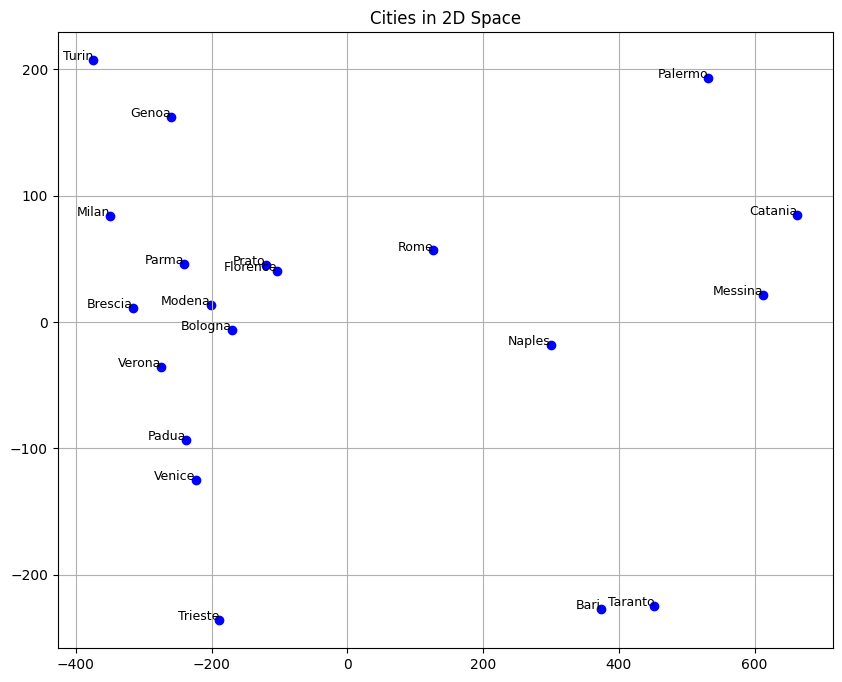

In [15]:
plotCities2D(test_problem_coordinates_2D, CITIES)
# Coordinates don't make sense by themselves, relative distances do.

In [16]:
def plotSolutionMap(coordinates_2D, solution_array, title='TSP Solution Path'):
    plt.figure(figsize=(10, 8))
    plt.scatter(coordinates_2D[:, 0], coordinates_2D[:, 1], color='blue')
    
    for i, city in enumerate(CITIES):
        plt.text(coordinates_2D[i, 0], coordinates_2D[i, 1], city, fontsize=9, ha='right')
    
    # Plot the path
    n = len(solution_array)
    for i in range(n):
        start_city = solution_array[i]
        end_city = solution_array[(i + 1) % n]
        plt.plot(
            [coordinates_2D[start_city, 0], coordinates_2D[end_city, 0]],
            [coordinates_2D[start_city, 1], coordinates_2D[end_city, 1]],
            color='blue'
        )

    plt.title(title)
    plt.grid()
    plt.show()

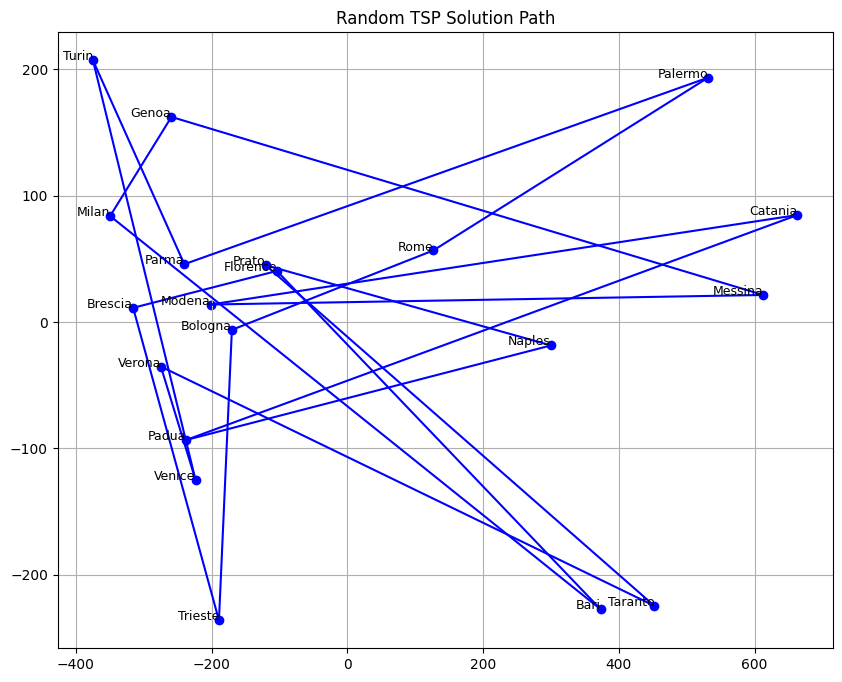

In [17]:
plotSolutionMap(test_problem_coordinates_2D, test_solution_array, title='Random TSP Solution Path')

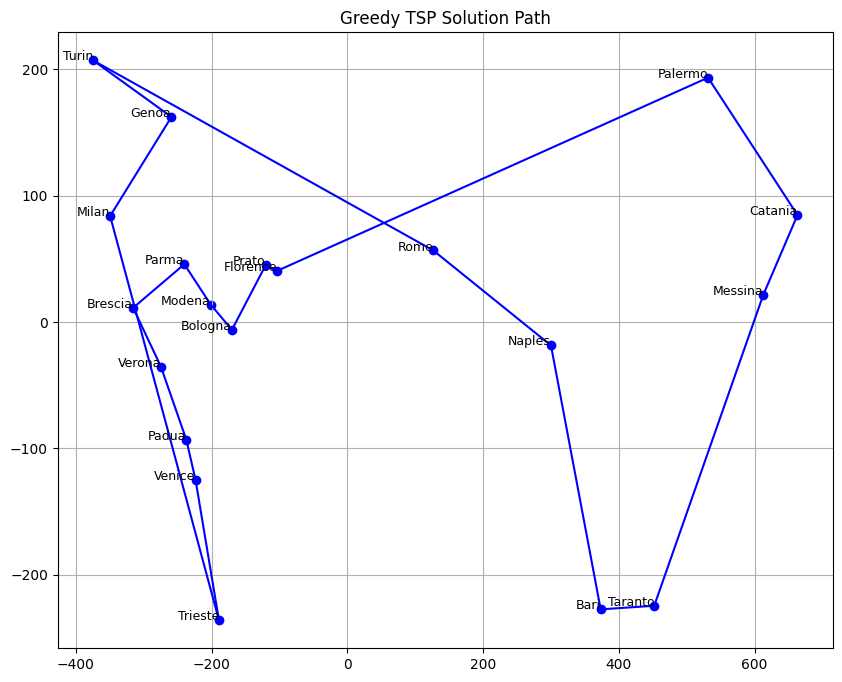

In [18]:
plotSolutionMap(test_problem_coordinates_2D, greedy_solution, title='Greedy TSP Solution Path')

## Simple algorithm

```
procedure 2optSwap(route, v1, v2) {
    1. take route[start] to route[v1] and add them in order to new_route
    2. take route[v1+1] to route[v2] and add them in reverse order to new_route
    3. take route[v2+1] to route[start] and add them in order to new_route
    return new_route;
}
```

Taken from https://en.wikipedia.org/wiki/2-opt


In [19]:
def swap2opt(solution_array, i, j):
    new_solution = solution_array.copy()
    new_solution[i+1:j] = solution_array[i+1:j][::-1]
    return new_solution

def totalDistance(solution_array, distance_matrix):
    total_distance = 0
    n = len(solution_array)
    for i in range(n):
        j = (i + 1) % n
        total_distance += distance_matrix[solution_array[i], solution_array[j]]
    return total_distance

def tspSimple(distance_matrix, init_solution, nb_iterations=1000):
    n = distance_matrix.shape[0]
    cities = list(range(n))
    
    best_route = init_solution
    best_distance = totalDistance(best_route, distance_matrix)
    evolution_distance = []
    evolution_route = []
    
    for _ in range(nb_iterations):
        current_route = np.random.permutation(cities)
        current_distance = totalDistance(current_route, distance_matrix)
        if current_distance < best_distance:
            best_route = current_route
            best_distance = current_distance
        evolution_distance.append(best_distance)
        evolution_route.append(best_route)
    return best_route, best_distance, evolution_distance, evolution_route

Optimisation when distance_matrix is well formed:

Building the new route and calculating the distance of the new route can be a very expensive operation, usually ${\displaystyle O(n)}$ where n is the number of vertices in the route. In a symmetric case (where the distance between A and B is the same as between B and A), this can be skipped by performing a ${\displaystyle O(1)}$ operation. Since a 2-opt operation involves removing 2 edges and adding 2 different edges we can subtract and add the distances of only those edges.

`lengthDelta = - dist(route[v1], route[v1+1]) - dist(route[v2], route[v2+1]) + dist(route[v1+1], route[v2+1]) + dist(route[v1], route[v2])`

(also wikipedia)

Simulated annealing to make the simple random algorithm above better.

In [20]:
# Works with swap2opt
# Only works when distance_matrix is symmetric
def fastDistance(path, n_cities, distance_matrix, current_distance, i, j):
    if i == j:
        return current_distance
    
    # Ensure i < j for consistent indexing
    if i > j:
        i, j = j, i
    
    # Handle edge case where segment is too small (no reversal happens)
    if j - i < 2:
        return current_distance
    
    # Get the city IDs at the relevant positions
    city_at_i = path[i]
    city_at_i_plus_1 = path[i + 1]
    city_at_j_minus_1 = path[j - 1]
    city_at_j = path[j % n_cities]
    
    new_distance = current_distance
    new_distance -= distance_matrix[city_at_i][city_at_i_plus_1]
    new_distance -= distance_matrix[city_at_j_minus_1][city_at_j]
    new_distance += distance_matrix[city_at_i][city_at_j_minus_1]
    new_distance += distance_matrix[city_at_i_plus_1][city_at_j]    
    return new_distance

In [21]:
def simulatedAnnealingSym(distance_matrix, init_solution, init_temp=100, cooling_rate=0.995, nb_iterations=1000):
    assert isMatrixSymmetric(distance_matrix), "Distance matrix must be symmetric."
    
    n = distance_matrix.shape[0]
    current_solution = init_solution
    current_distance = totalDistance(current_solution, distance_matrix)
    best_solution = current_solution.copy()
    best_distance = current_distance
    evolution_distance = []
    evolution_solution = []
    temperature = init_temp
    
    for k in range(nb_iterations):
        i = np.random.randint(0, n - 1)
        j = np.random.randint(i + 1, n)
        new_solution = swap2opt(current_solution, i, j)
        # new_distance = current_distance - distance_matrix[i, i+1] - distance_matrix[j, (j + 1) % n] + distance_matrix[i, j] + distance_matrix[i + 1, (j + 1) % n]
        # new_distance = totalDistance(new_solution, distance_matrix)
        new_distance = fastDistance(current_solution, n, distance_matrix, current_distance, i, j)
        # assert np.isclose(new_distance, new_distance2), f"Fast distance calculation error at iteration {k}: {new_distance} vs {new_distance2}"
        if new_distance <= current_distance:
            current_solution = new_solution
            current_distance = new_distance
            if current_distance < best_distance:
                best_solution = current_solution.copy()
                best_distance = current_distance
        else:
            acceptance_probability = np.exp((current_distance - new_distance) / temperature)
            if np.random.rand() < acceptance_probability:
                current_solution = new_solution
                current_distance = new_distance
        temperature *= cooling_rate
        evolution_distance.append(best_distance)
        evolution_solution.append(best_solution.copy())
    return best_solution, best_distance, evolution_distance, evolution_solution

Best solution found: [15, 8, 12, 9, 4, 2, 0, 7, 6, 14, 10, 13, 11, 16, 1, 3, 5, 18, 19, 17]
Total distance of best solution: 3218.740000000007


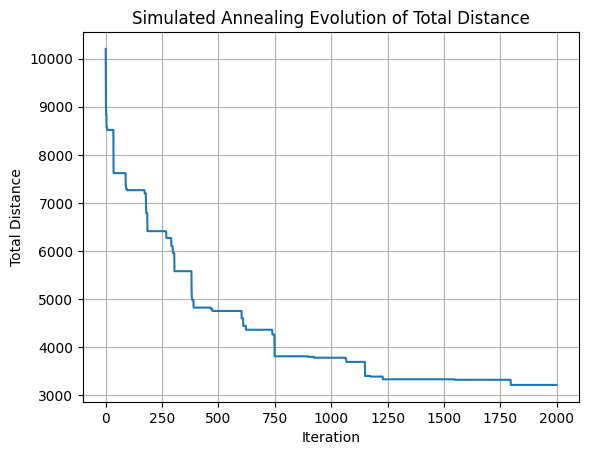

In [22]:
sol, dist, evol_dist, evol_sol = simulatedAnnealingSym(test_problem, test_solution_array, init_temp=1000, nb_iterations=2000)
print("Best solution found:", sol)
print("Total distance of best solution:", dist)
plotEvolution(evol_dist, title="Simulated Annealing Evolution of Total Distance")

In [23]:
# Animate TSP evolution and save as GIF (uses existing variables/functions in the notebook)
# Requires: test_problem_coordinates_2D, CITIES, test_solution_array, sol, evol_sol, test_problem, totalDistance

fig, ax = plt.subplots(figsize=(10, 8))

# Choose number of frames (sample evol_sol to reasonable length)
n_frames = 120
n_evol = len(evol_sol)
sampled_indices = np.linspace(0, max(0, n_evol - 1), max(1, n_frames - 2), dtype=int)
frames = [test_solution_array] + [evol_sol[i] for i in sampled_indices] + [sol]

# Ensure all frames are lists (some entries might be numpy arrays)
frames = [list(f) for f in frames]

# Precompute city coordinates
coords = test_problem_coordinates_2D
x = coords[:, 0]
y = coords[:, 1]

def draw_route(ax, route):
    ax.scatter(x, y, color='blue', zorder=2)
    for i, city in enumerate(CITIES):
        ax.text(x[i], y[i], city, fontsize=9, ha='right', zorder=3)
    seq = route + [route[0]]
    seq = np.array(seq, dtype=int)
    ax.plot(coords[seq, 0], coords[seq, 1], color='tab:blue', linewidth=2, zorder=1)
    ax.set_title('')
    ax.set_aspect('equal', 'box')
    ax.grid(True)

def update(frame_idx):
    ax.clear()
    route = frames[frame_idx]
    draw_route(ax, route)
    dist_val = totalDistance(route, test_problem)
    ax.set_title(f'Frame {frame_idx+1}/{len(frames)}  —  Distance: {dist_val:.2f}')

anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=100)

# Save GIF using PillowWriter
gif_path = 'tsp_evolution.gif'
writer = animation.PillowWriter(fps=10)
anim.save(gif_path, writer=writer)
plt.close(fig)

print(f"Saved animation to {gif_path}")

Saved animation to tsp_evolution.gif


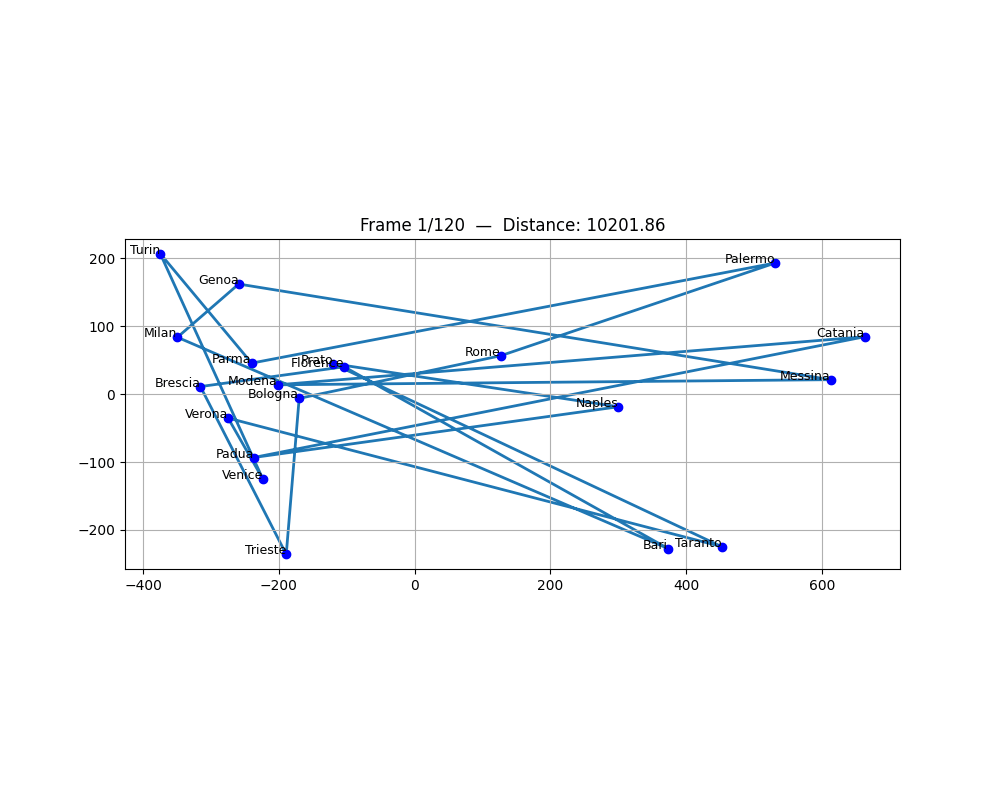

In [24]:
from IPython.display import Image, display

# Display the saved GIF inline
display(Image(filename=gif_path))